In [94]:
# Gerekli Kütüphane ve Fonksiyonlar
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier



pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [96]:

# GENEL RESİM


def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


# Dosyayı okuma işlemini fonksiyon dışında yapalım
df = pd.read_csv("ENB2012_data.csv")

check_df(df)


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)





##################### Shape #####################
(768, 10)
##################### Types #####################
X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y1    float64
Y2    float64
dtype: object
##################### Head #####################
     X1      X2      X3      X4    X5  X6    X7  X8     Y1     Y2
0 0.980 514.500 294.000 110.250 7.000   2 0.000   0 15.550 21.330
1 0.980 514.500 294.000 110.250 7.000   3 0.000   0 15.550 21.330
2 0.980 514.500 294.000 110.250 7.000   4 0.000   0 15.550 21.330
3 0.980 514.500 294.000 110.250 7.000   5 0.000   0 15.550 21.330
4 0.900 563.500 318.500 122.500 7.000   2 0.000   0 20.840 28.280
##################### Tail #####################
       X1      X2      X3      X4    X5  X6    X7  X8     Y1     Y2
763 0.640 784.000 343.000 220.500 3.500   5 0.400   5 17.880 21.400
764 0.620 808.500 367.500 220.500 3.500   2 0.400   5 16.540 16.880
765 0.620 808.500 367.500 220.500 3.50

          X3  Ratio
X3                 
294.000  192 25.000
318.500  192 25.000
343.000  128 16.667
416.500   64  8.333
245.000   64  8.333
269.500   64  8.333
367.500   64  8.333
##########################################


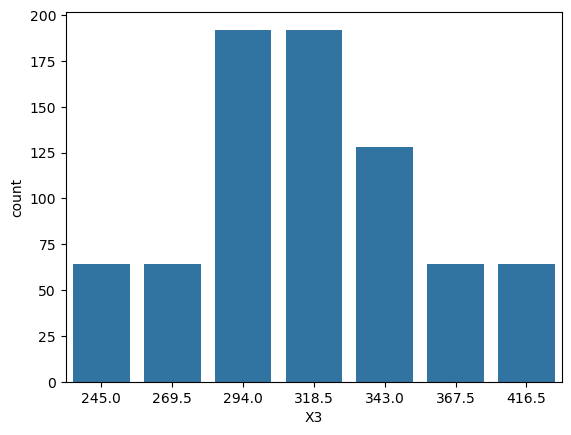

          X4  Ratio
X4                 
220.500  384 50.000
147.000  192 25.000
122.500  128 16.667
110.250   64  8.333
##########################################


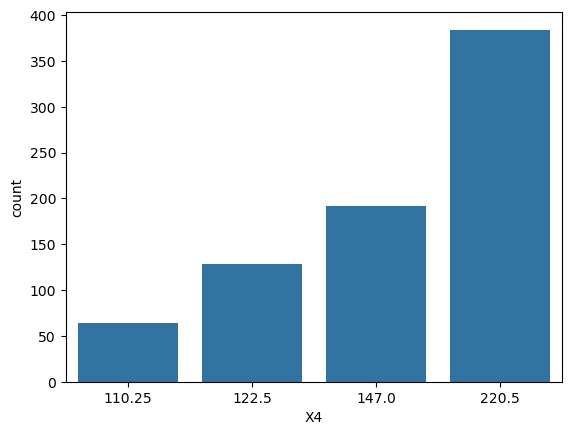

        X5  Ratio
X5               
7.000  384 50.000
3.500  384 50.000
##########################################


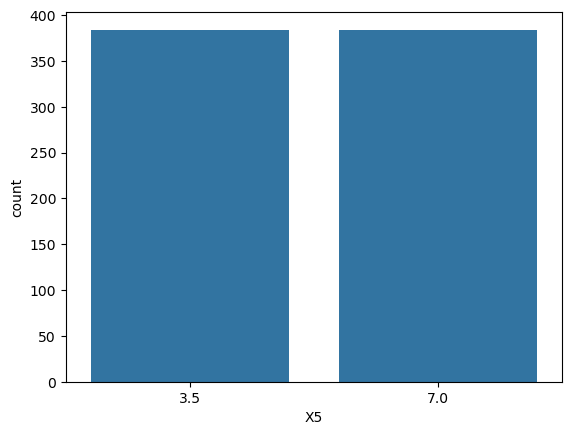

     X6  Ratio
X6            
2   192 25.000
3   192 25.000
4   192 25.000
5   192 25.000
##########################################


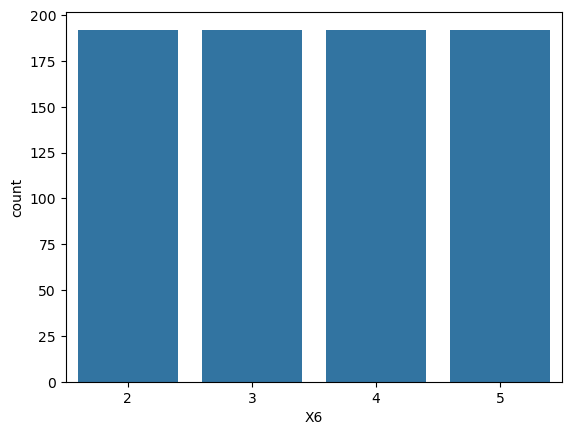

        X7  Ratio
X7               
0.100  240 31.250
0.250  240 31.250
0.400  240 31.250
0.000   48  6.250
##########################################


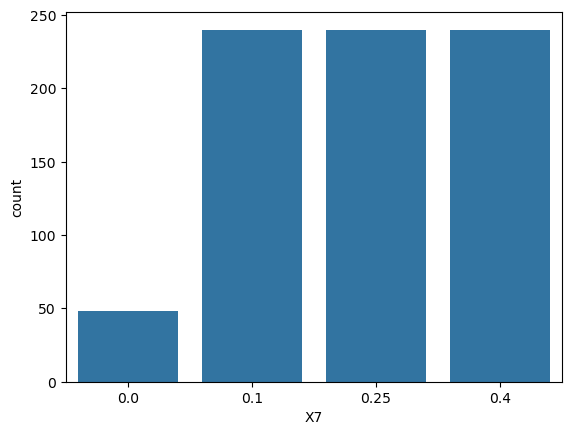

     X8  Ratio
X8            
1   144 18.750
2   144 18.750
3   144 18.750
4   144 18.750
5   144 18.750
0    48  6.250
##########################################


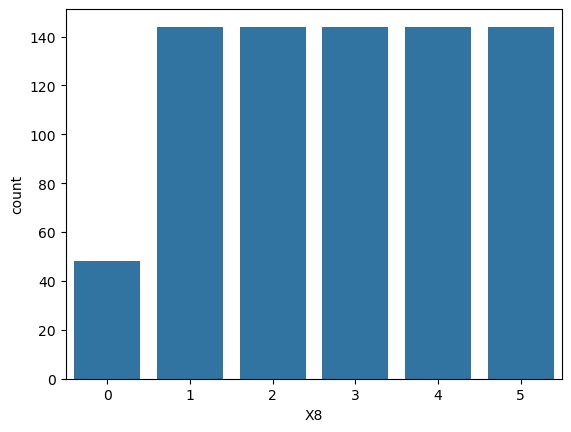

In [98]:
# 2. Kategorik Değişken Analizi (Analysis of Categorical Variables)
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

count   768.000
mean      0.764
std       0.106
min       0.620
5%        0.620
10%       0.640
20%       0.660
30%       0.690
40%       0.710
50%       0.750
60%       0.790
70%       0.820
80%       0.860
90%       0.900
95%       0.980
99%       0.980
max       0.980
Name: X1, dtype: float64


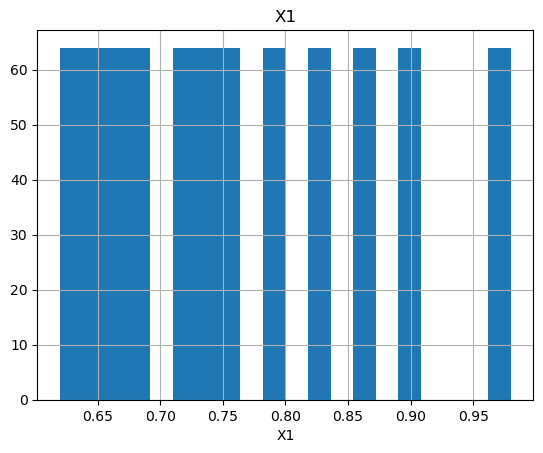

count   768.000
mean    671.708
std      88.086
min     514.500
5%      514.500
10%     563.500
20%     588.000
30%     612.500
40%     637.000
50%     673.750
60%     710.500
70%     735.000
80%     759.500
90%     784.000
95%     808.500
99%     808.500
max     808.500
Name: X2, dtype: float64


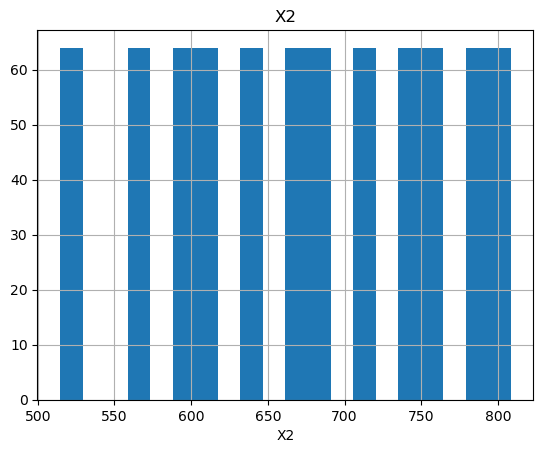

count   768.000
mean     22.307
std      10.090
min       6.010
5%       10.464
10%      11.217
20%      12.630
30%      14.320
40%      15.230
50%      18.950
60%      25.668
70%      29.089
80%      32.508
90%      36.703
95%      39.860
99%      42.090
max      43.100
Name: Y1, dtype: float64


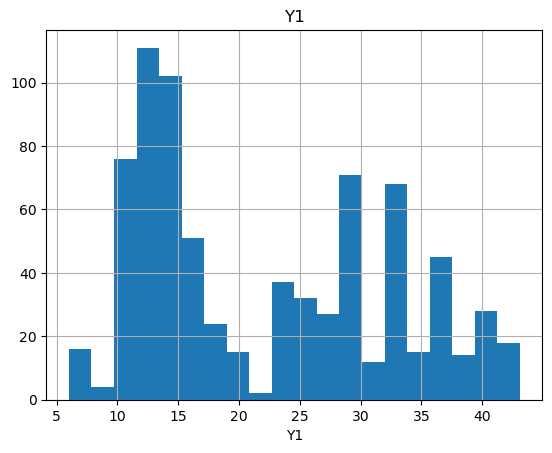

count   768.000
mean     24.588
std       9.513
min      10.900
5%       13.617
10%      14.237
20%      15.116
30%      16.278
40%      17.720
50%      22.080
60%      28.286
70%      31.263
80%      34.062
90%      37.422
95%      40.037
99%      45.543
max      48.030
Name: Y2, dtype: float64


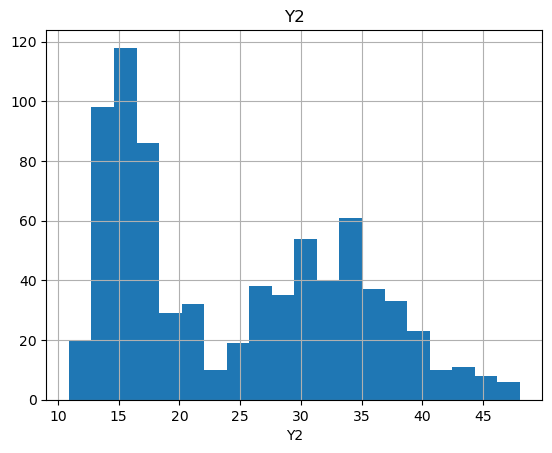

In [99]:
# 3. Sayısal Değişken Analizi (Analysis of Numerical Variables)
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [101]:
# 4. Hedef Değişken Analizi (Analysis of Target Variable)
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Y1", col)

         TARGET_MEAN
X3                  
245.000       11.887
269.500       12.040
294.000       22.863
318.500       23.334
343.000       27.612
367.500       14.283
416.500       35.664


         TARGET_MEAN
X4                  
110.250       27.646
122.500       33.647
147.000       30.905
220.500       13.339


       TARGET_MEAN
X5                
3.500       13.339
7.000       31.276


    TARGET_MEAN
X6             
2        22.313
3        22.381
4        22.260
5        22.275


       TARGET_MEAN
X7                
0.000       14.286
0.100       20.357
0.250       22.757
0.400       25.412


    TARGET_MEAN
X8             
0        14.286
1        23.026
2        22.934
3        22.681
4        22.887
5        22.681




In [102]:
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Y2", col)

         TARGET_MEAN
X3                  
245.000       14.810
269.500       15.035
294.000       25.124
318.500       25.906
343.000       30.233
367.500       15.244
416.500       36.407


         TARGET_MEAN
X4                  
110.250       29.217
122.500       35.114
147.000       33.060
220.500       16.071


       TARGET_MEAN
X5                
3.500       16.071
7.000       33.104


    TARGET_MEAN
X6             
2        24.605
3        24.313
4        24.480
5        24.954


       TARGET_MEAN
X7                
0.000       19.706
0.100       22.936
0.250       24.893
0.400       26.911


    TARGET_MEAN
X8             
0        19.706
1        25.180
2        24.997
3        24.659
4        25.015
5        24.715




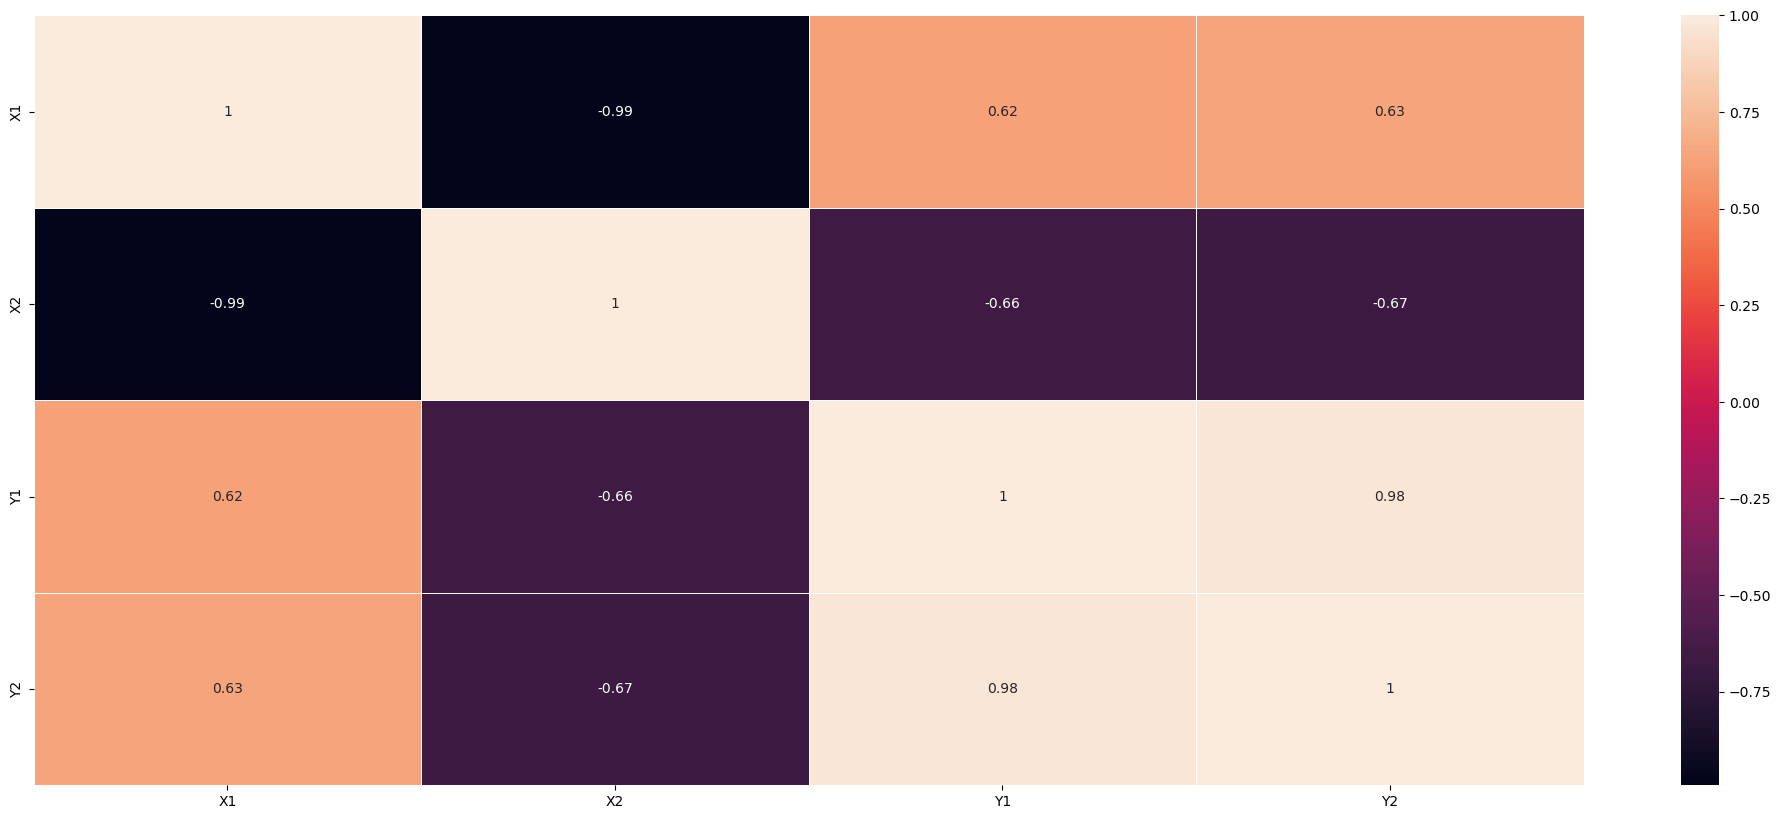

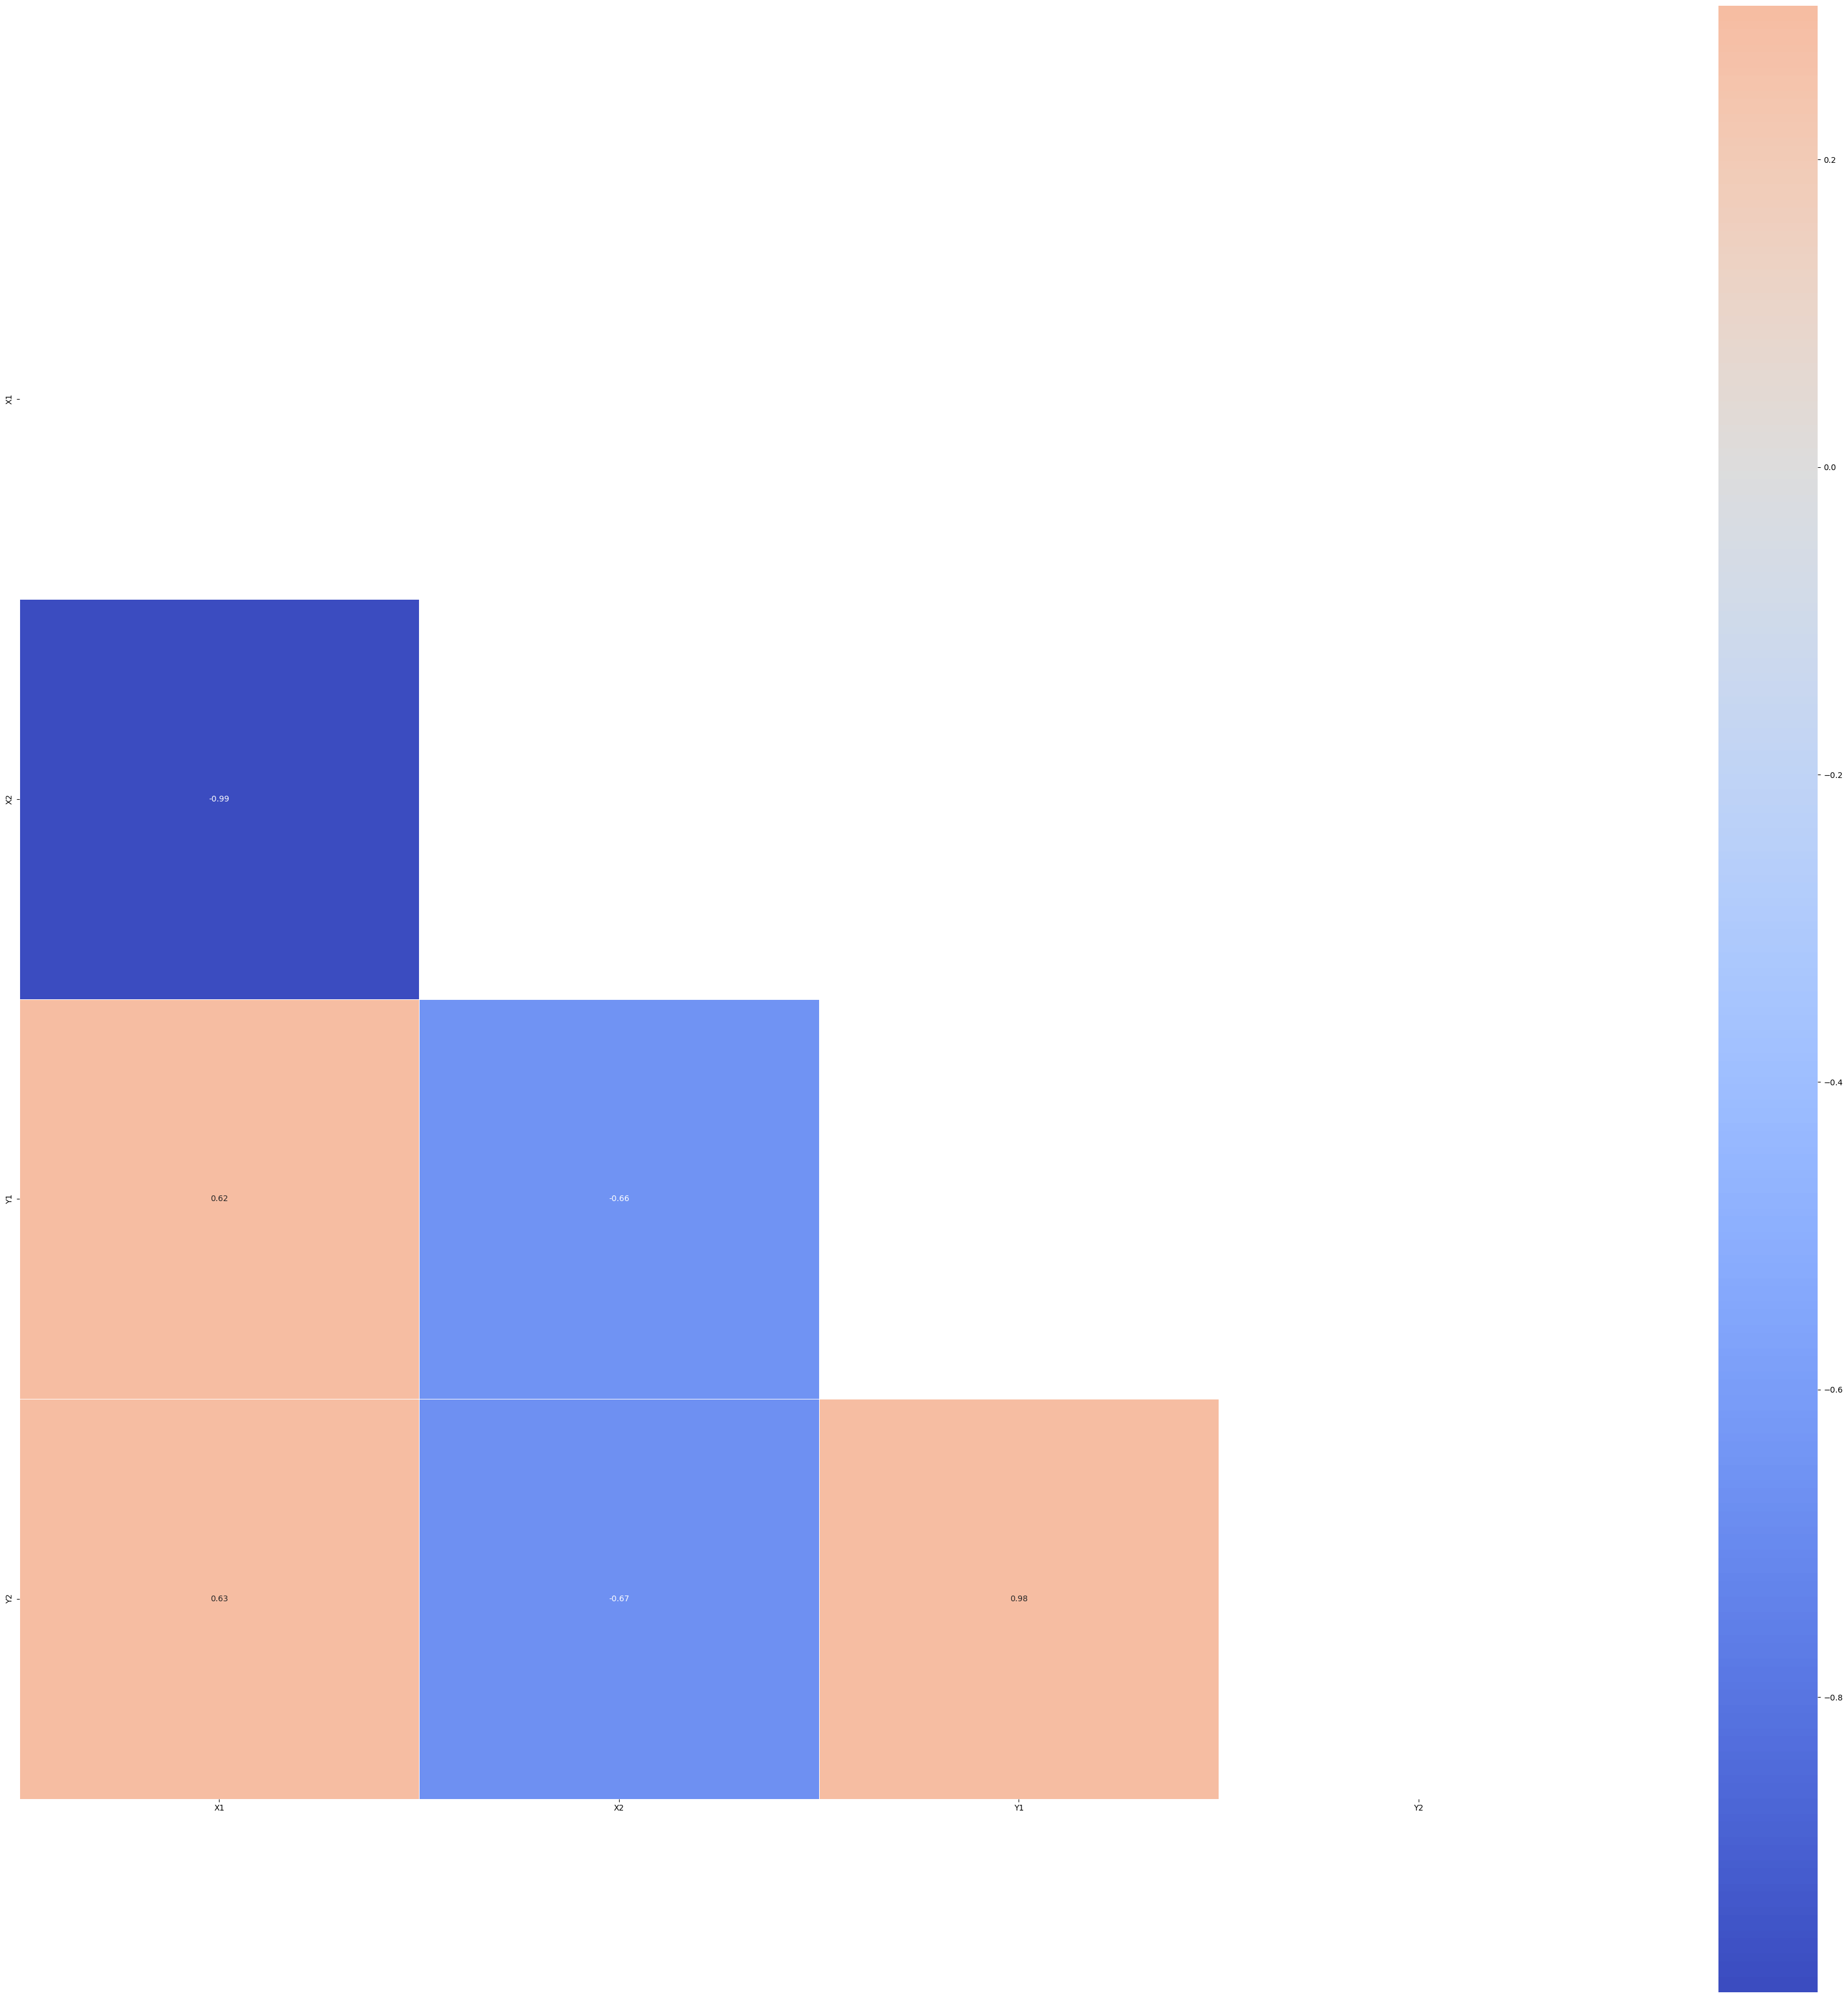

X1 0.6222721790646623
X2 -0.6581202267776199
Y2 0.9758618134328587


In [106]:
# 5. Korelasyon Analizi (Analysis of Correlation)
df[num_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(df[num_cols].corr(), annot=True, linewidths=.5, ax=ax)
plt.show()



plt.figure(figsize=(45,45))
corr=df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df[num_cols].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show(block=True)


def find_correlation(dataframe, numeric_cols, corr_limit=0.60):
    high_correlations = []
    low_correlations = []
    for col in numeric_cols:
        if col == "Y1":
            pass
        else:
            correlation = dataframe[[col, "Y1"]].corr().loc[col, "Y1"]
            print(col, correlation)
            if abs(correlation) > corr_limit:
                high_correlations.append(col + ": " + str(correlation))
            else:
                low_correlations.append(col + ": " + str(correlation))
    return low_correlations, high_correlations


low_corrs, high_corrs = find_correlation(df, num_cols)


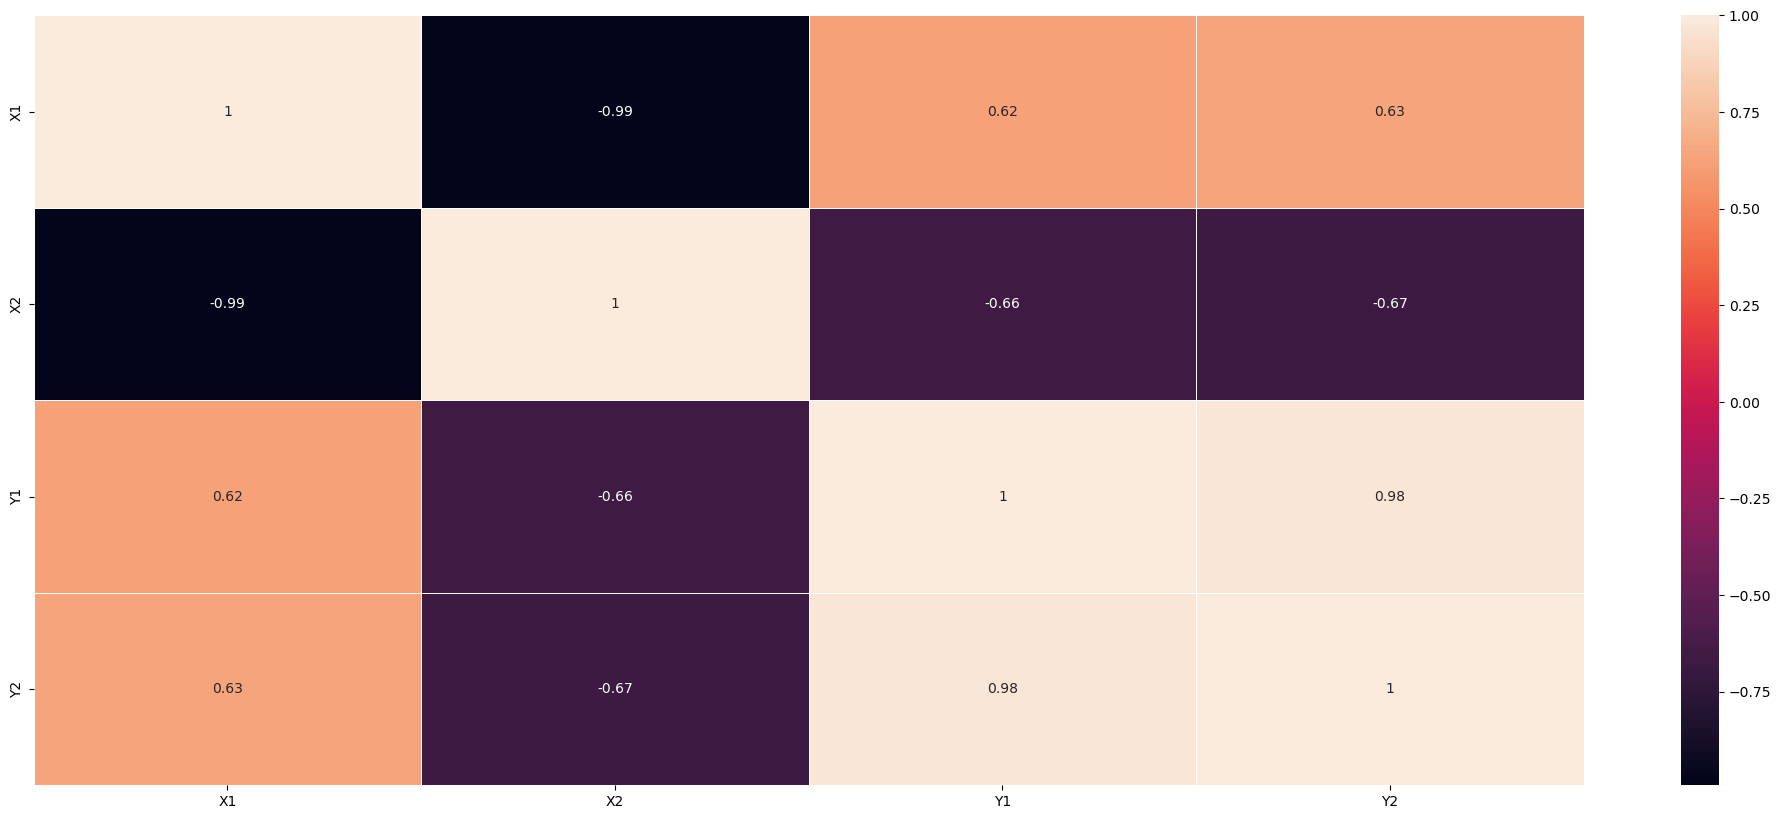

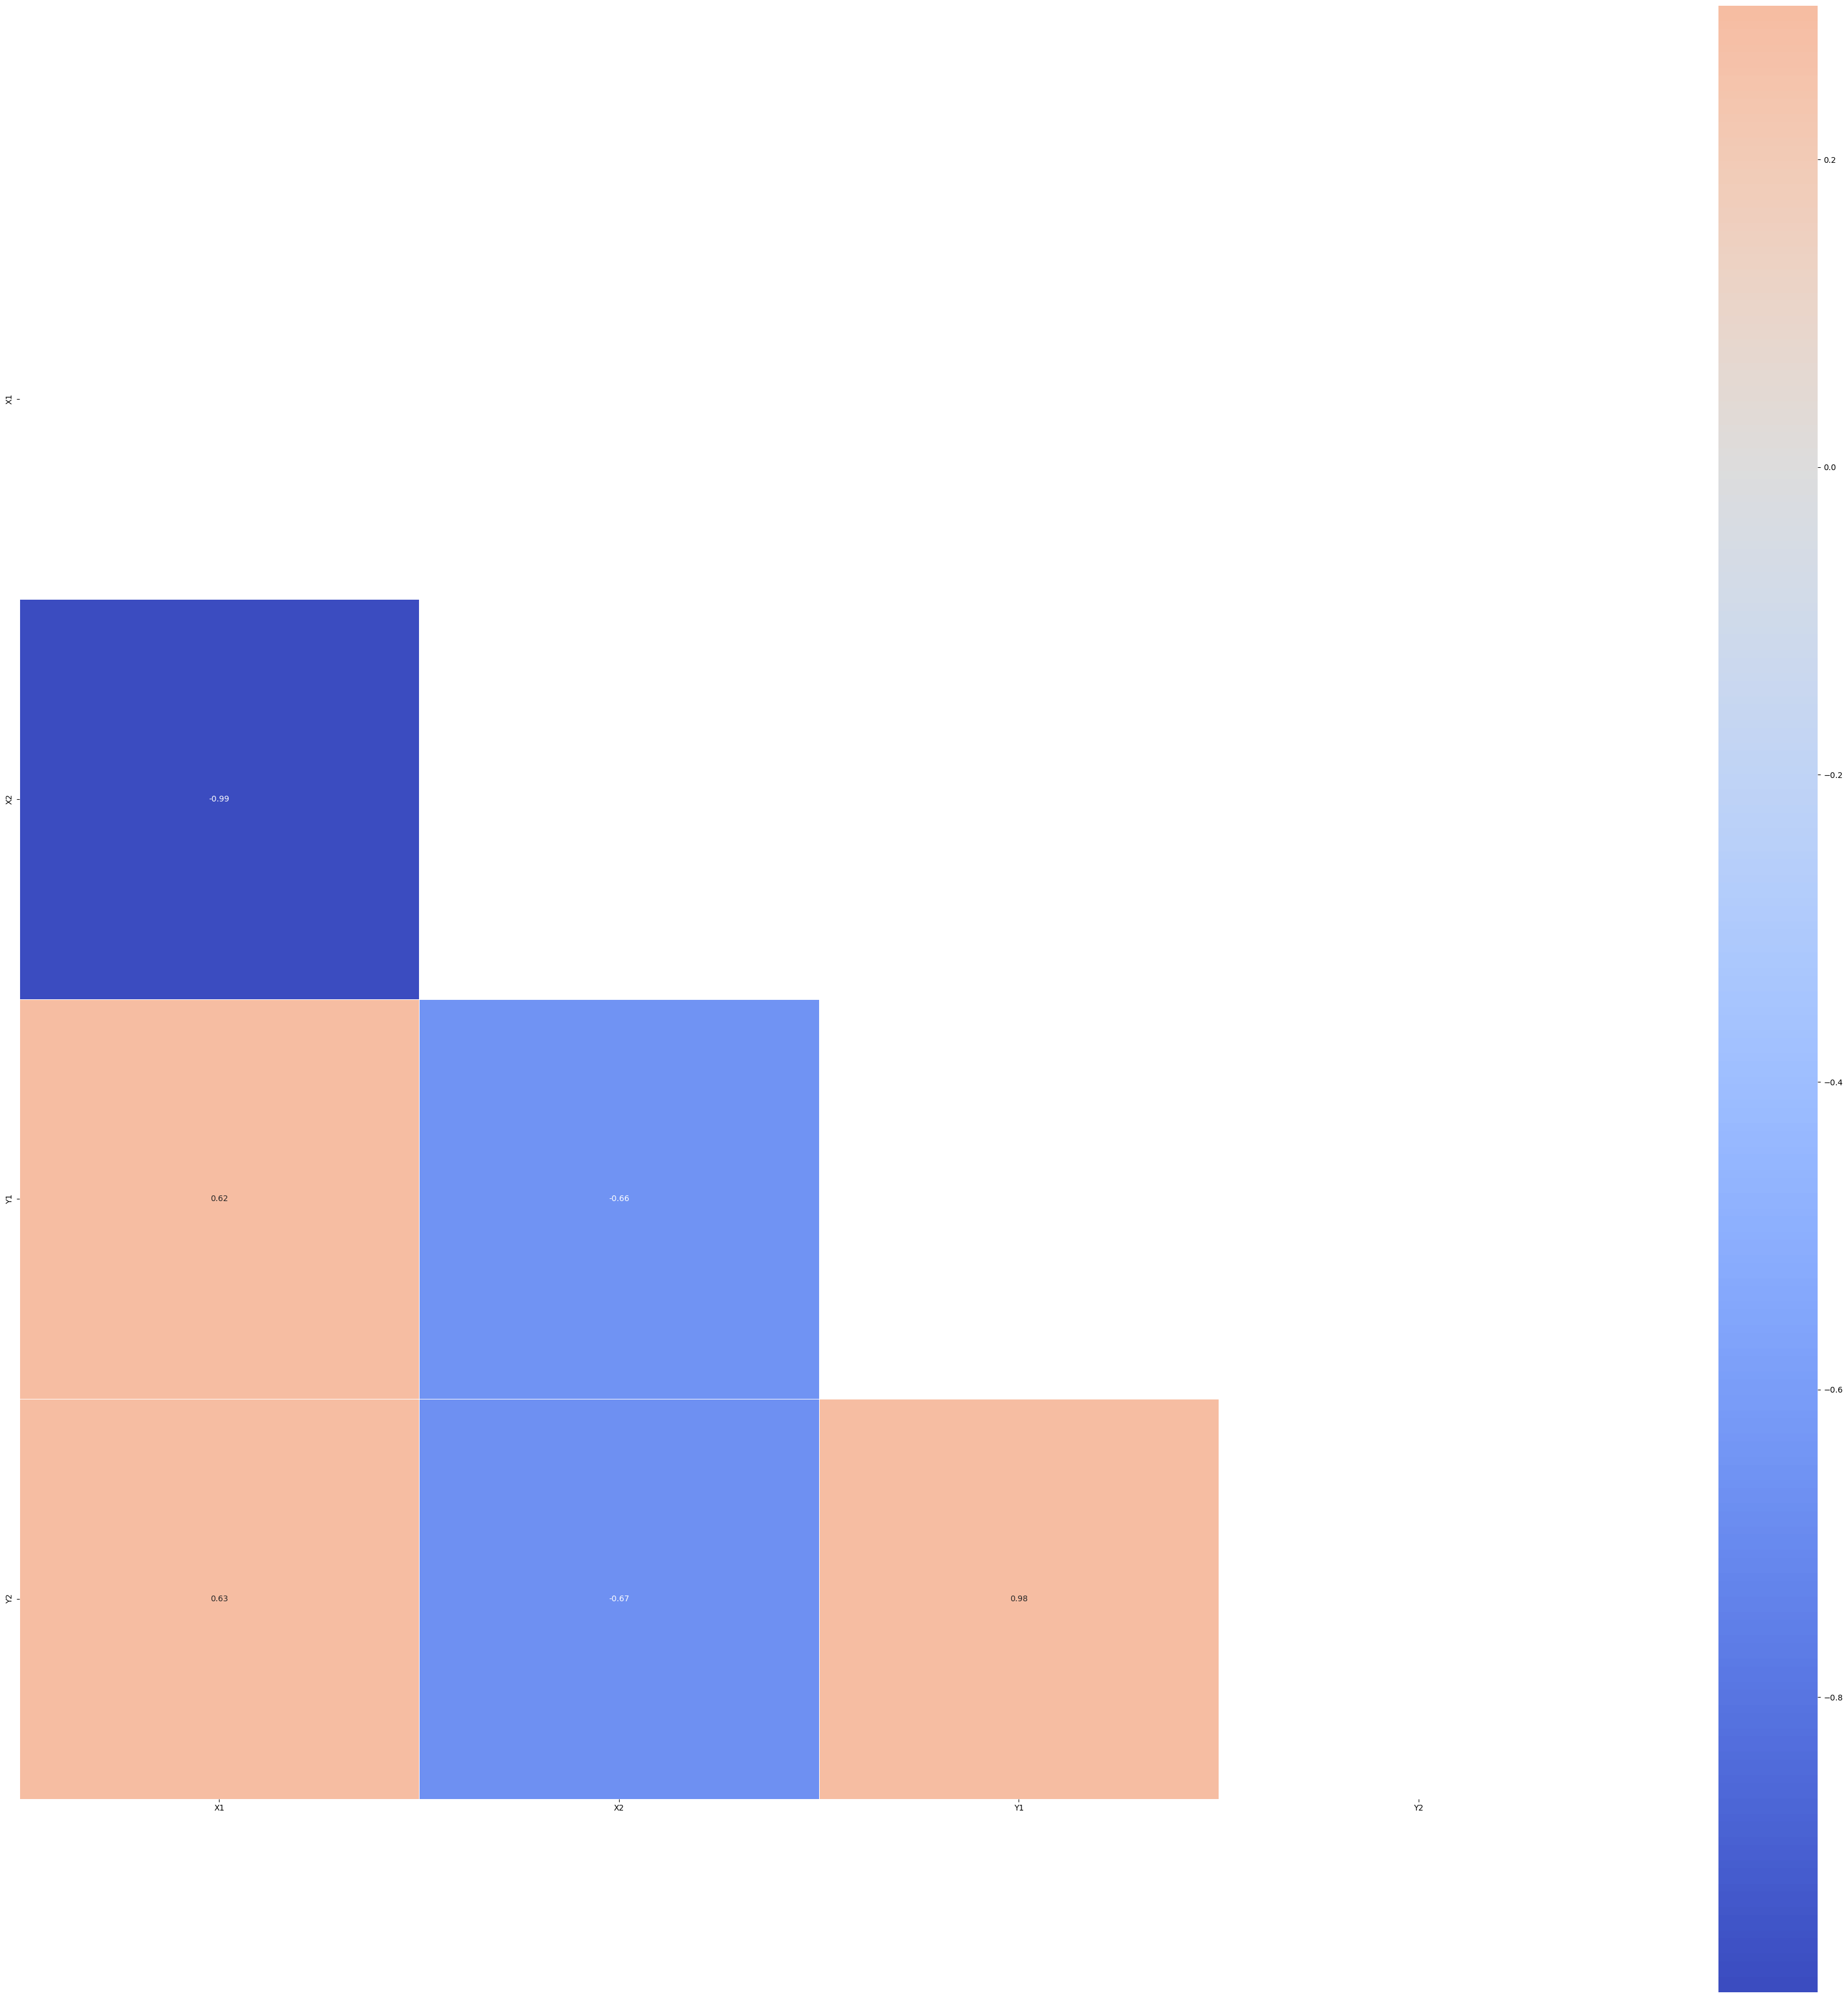

X1 0.6222721790646623
X2 -0.6581202267776199
Y2 0.9758618134328587
X1 0.6343390663353582
X2 -0.672998933354486
Y1 0.9758618134328587


In [107]:
# 5. Korelasyon Analizi (Analysis of Correlation)
df[num_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(df[num_cols].corr(), annot=True, linewidths=.5, ax=ax)
plt.show()


# correlation with the final state of the variables
plt.figure(figsize=(45,45))
corr=df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df[num_cols].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show(block=True)



def find_correlation(dataframe, numeric_cols, corr_limit=0.60):
    high_correlations = []
    low_correlations = []
    for col in numeric_cols:
        if col == "Y1":
            pass
        else:
            correlation = dataframe[[col, "Y1"]].corr().loc[col, "Y1"]
            print(col, correlation)
            if abs(correlation) > corr_limit:
                high_correlations.append(col + ": " + str(correlation))
            else:
                low_correlations.append(col + ": " + str(correlation))
    return low_correlations, high_correlations


low_corrs, high_corrs = find_correlation(df, num_cols)

def find_correlation(dataframe, numeric_cols, corr_limit=0.60):
    high_correlations = []
    low_correlations = []
    for col in numeric_cols:
        if col == "Y2":
            pass
        else:
            correlation = dataframe[[col, "Y2"]].corr().loc[col, "Y2"]
            print(col, correlation)
            if abs(correlation) > corr_limit:
                high_correlations.append(col + ": " + str(correlation))
            else:
                low_correlations.append(col + ": " + str(correlation))
    return low_correlations, high_correlations


low_corrs, high_corrs = find_correlation(df, num_cols)

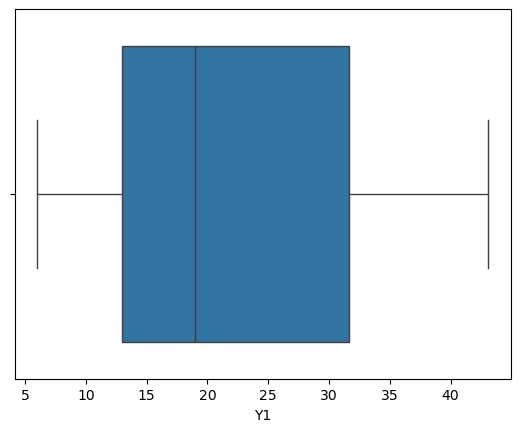

X1 False
X2 False
Y1 False
Y2 False


In [108]:
# GELİŞMİŞ FONKSİYONEL KEŞİFÇİ VERİ ANALİZİ (ADVANCED FUNCTIONAL EDA)
# 1. Outliers (Aykırı Değerler)
sns.boxplot(x=df["Y1"], data=df)
plt.show(block=True)


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

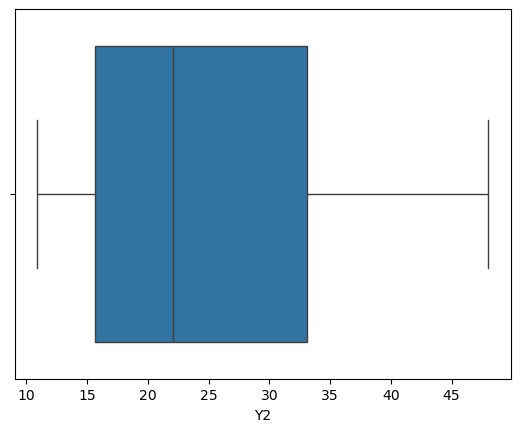

X1 False
X2 False
Y1 False
Y2 False


In [110]:
# 1. Outliers (Aykırı Değerler)
sns.boxplot(x=df["Y2"], data=df)
plt.show(block=True)


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [111]:
# 2. Missing Values (Eksik Değerler)
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [116]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[num_cols[:-2]])
scaled_df = pd.DataFrame(scaled_features, columns=num_cols[:-2])

# Ölçeklendirilmiş özellikleri hedef değişkenlerle birleştirin
scaled_df['Y1'] = df['Y1']
scaled_df['Y2'] = df['Y2']

# Verileri eğitim ve test kümelerine bölün
X = scaled_df.drop(columns=['Y1', 'Y2'])
y = scaled_df['Y1']  # Isıtma Yükünü Tahmin Etme (Y1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
#Linear Regression Model
model = LinearRegression()

model.fit(X_train, y_train)

#Tahminlerde bulun
y_pred = model.predict(X_test)

# Modeli Değerlendirin
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")


Model Evaluation Metrics:
Mean Squared Error (MSE): 56.09109494281748
R-squared (R²): 0.46186068350297804


In [120]:
# Değişkenin önemi (katsayıları)
feature_importance = pd.DataFrame({
    'Değişken': X.columns,
    'Katsayıları': model.coef_
}).sort_values(by='Katsayıları', ascending=False)

print("\nDeğişken Onemi:")
print(feature_importance)


Değişken Onemi:
  Değişken  Katsayıları
0       X1      -18.799
1       X2      -25.242


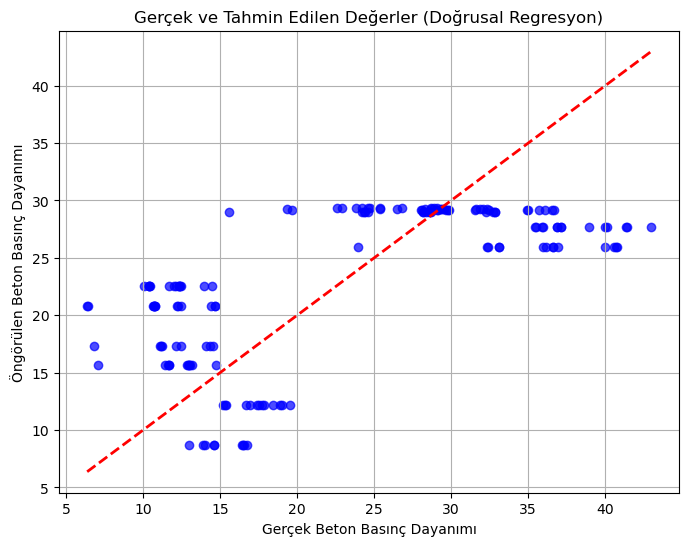

In [122]:
# Doğrusal Regresyon Grafiği
# Gerçek ve Tahmin Edilen Değerleri çizin
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Gerçek Beton Basınç Dayanımı")
plt.ylabel("Öngörülen Beton Basınç Dayanımı")
plt.title("Gerçek ve Tahmin Edilen Değerler (Doğrusal Regresyon)")
plt.grid(True)
plt.show()

In [124]:
X = df.drop(['Y1', 'Y2'], axis=1)  
y1 = df['Y1']  # Isıtma yükü (Y1)
y2 = df['Y2']  # Soğutma yükü (Y2)

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y1_train)

RandomForestRegressor(random_state=42)

In [126]:
y1_pred = rf_model.predict(X_test)
mse = mean_squared_error(y1_test, y1_pred)
r2 = r2_score(y1_test, y1_pred)
model_score = rf_model.score(X_test, y1_test)

print(f"Mean Squared Error (Isıtma Yükü): {mse}")
print(f"R^2 Score (Isıtma Yükü): {r2}")
print(f"Model Score (Isıtma Yükü): {model_score}")

Mean Squared Error (Isıtma Yükü): 0.24088222909090704
R^2 Score (Isıtma Yükü): 0.9976889700896121
Model Score (Isıtma Yükü): 0.9976889700896121


In [128]:
# Aynı işlemleri soğutma yükü (Y2) için yapma

X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)
rf_model.fit(X_train, y2_train)

RandomForestRegressor(random_state=42)

In [130]:
y2_pred = rf_model.predict(X_test)
mse2 = mean_squared_error(y2_test, y2_pred)
r2_2 = r2_score(y2_test, y2_pred)
model_score = rf_model.score(X_test, y2_test)

print(f"Mean Squared Error (Soğutma Yükü): {mse2}")
print(f"R^2 Score (Soğutma Yükü): {r2_2}")
print(f"Model Score (Soğutma Yükü): {model_score}")

Mean Squared Error (Soğutma Yükü): 2.9340964745454556
R^2 Score (Soğutma Yükü): 0.9683338660414131
Model Score (Soğutma Yükü): 0.9683338660414131
